In [1]:
import torch
import json

import pandas as pd
import matplotlib.pyplot as plt

from transformers import OPTForCausalLM, AutoTokenizer
from datasets import load_dataset, Dataset

from data_utils import load_glue_datasets,\
    load_hans_dataset,\
    load_mnli_mismatched_dataset,\
    load_paws_qqp_dataset,\
    load_cola_ood_dataset,\
    task_to_keys
from context_utils import create_few_shot_context

In [2]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
def json_pretty(json_string):
    print(json.dumps(json_string,indent=4))
    return None

def label_to_text(text_label, label):
    return text_label[label]

def teacher_create_prompt(premise, hypothesis, label=None):
    prompt = f"\nPremise: {premise}, \nHypothesis: {hypothesis}"
    if label is not None:
        prompt += f",\nLabel: {label_to_text(label)}"
    if label is None:
        prompt += f",\nLabel:"
    return prompt

def student_create_prompt(premise, hypothesis, label=None):
    prompt = f"Label if this is entailment or contradiction.\nPremise: {premise},\nHypothesis: {hypothesis},\nLabel:"
    return prompt

def create_extended_prompt(context_examples, query_example):
    context_prompt = ""
    for example in context_examples:
        premise = example['premise']
        hypothesis = example['hypothesis']
        label = example['label']
        context_prompt += teacher_create_prompt(premise, hypothesis, label) + "\n"
    
    query_premise = query_example['premise']
    query_hypothesis = query_example['hypothesis']
    query_prompt = teacher_create_prompt(query_premise, query_hypothesis) 
    return context_prompt + query_prompt

## Tokenizer + Models

In [4]:
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m") # tokenizer
teacher_model = OPTForCausalLM.from_pretrained("facebook/opt-125m") # teacher model
student_model = OPTForCausalLM.from_pretrained("facebook/opt-125m") # student model

## Datasets

In [5]:
data_set_used='mnli'
datasets, labels, num_labels = load_glue_datasets(data_set_used)

In [6]:
def create_batch_token(dataset_name, datasets,tokenizer,num_shots=1, device = 'cpu', split='train',len_subset=300):
    batch = []
    datasets = datasets[split]
    for i in range(0, len_subset,num_shots):
        context, student_context, indices = create_few_shot_context(
            dataset_name, datasets,
            num_shots,
            from_indices=list(range(i, i+num_shots))
            )
        if split == 'train':
            token_data= {
                'context':(tokenizer(context, return_tensors="pt")).to(device),
                'query':(tokenizer(student_context, return_tensors="pt")).to(device)
            }
        else:
            token_data = (tokenizer(student_context, return_tensors="pt")).to(device)
        batch.append(token_data)
    return batch

train_data = create_batch_token(data_set_used, datasets,num_shots=3,tokenizer=tokenizer, device=device)
student_prompt_token = create_batch_token(data_set_used, datasets,num_shots=1,tokenizer=tokenizer, device=device,split= 'validation_matched')


In [7]:
# Assuming `losses` is the list of epoch losses returned from the `train` function
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

Epoch 1, Total Loss: 0.7595107890665531
Epoch 2, Total Loss: 0.47735405651231605
Epoch 3, Total Loss: 0.4136891320037345
Epoch 4, Total Loss: 0.4082316296796004
Epoch 5, Total Loss: 0.3421781777093808
Epoch 6, Total Loss: 0.3372617778368294
Epoch 7, Total Loss: 0.329914399733146
Epoch 8, Total Loss: 0.3152327347391595
Epoch 9, Total Loss: 0.28487325335542363
Epoch 10, Total Loss: 0.2887382712215185
Total loss : 0.17324296273291112


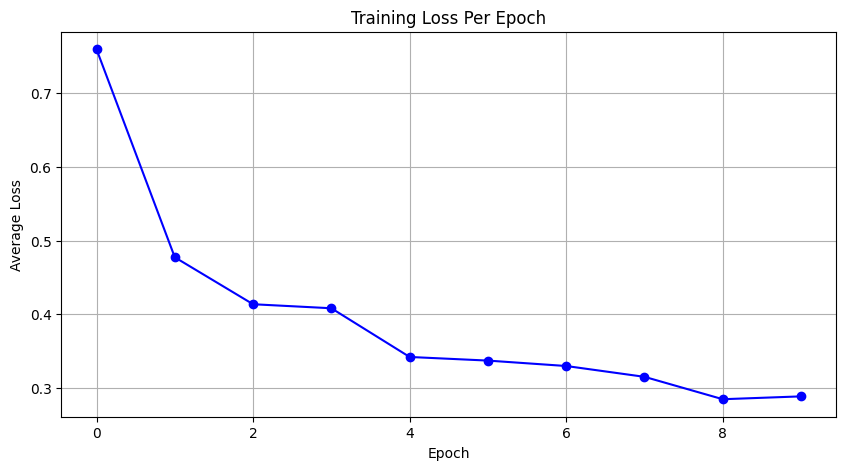

In [8]:
def train(data, epochs=10, batch_size=16, device='cpu'):
    student_model.to(device)
    teacher_model.to(device)
    
    student_model.train()
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=0.001)
    epoch_losses = []


    for epoch in range(epochs):
        total_loss = 0
        num_batches = len(data) // batch_size 
        
        for i in range(num_batches):
            batch_loss = 0
            for j in range(batch_size):
                index = i * batch_size + j
                
                teacher_inputs = data[index]['context'].to(device)
                student_inputs = data[index]['query'].to(device)
                                
                teacher_outputs = teacher_model.generate(**teacher_inputs, max_length=teacher_inputs['input_ids'].shape[-1] + 1, output_scores=True, return_dict_in_generate=True)
                teacher_probs = torch.nn.functional.softmax(teacher_outputs.scores[0], dim=-1)
                
                student_logits = student_model(**student_inputs).logits
                student_probs = torch.nn.functional.softmax(student_logits[:, -1, :], dim=-1)
                
                kl_divergence = torch.nn.functional.kl_div(student_probs.log(), teacher_probs, reduction='batchmean')
                
                optimizer.zero_grad()
                kl_divergence.backward()
                optimizer.step()

                batch_loss += kl_divergence.item()

            # Average loss for the batch
            batch_loss /= batch_size
            total_loss += batch_loss
            # print(f"Epoch {epoch + 1}, Batch {i + 1}, Average Loss: {batch_loss}")


        # Average loss for the epoch
        epoch_loss = total_loss / num_batches
        epoch_losses.append(epoch_loss)

        print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss}")
        
    print(f"Total loss : {total_loss/epochs}")
    plot_losses(epoch_losses)
    # torch.save(student_model, './models/student.pth')


train(train_data, device=device)


In [9]:
def predict(model, source, target=None, device='cpu'):
    predict = []
    for token in source:
        output = model.generate(**token, max_length=token['input_ids'].shape[-1] + 1).to(device)
        decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
        predicted_label = decoded_output.split("Label:")[-1].strip().split('.')[0].strip()
        predict.append(predicted_label)
        
    return predict

student_prompt_token = create_batch_token(data_set_used, datasets,num_shots=1,tokenizer=tokenizer, device=device,split= 'validation_matched')
predict = predict(student_model, student_prompt_token, device=device)  


In [10]:
predict

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Prem',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Hyp',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ''